### TP2: Hurst

Libraries import

In [46]:
import numpy                 as np
import matplotlib.pyplot     as plt
import pandas                as pd
import tensorflow            as tf
import pyarrow               as pa
import pyarrow.parquet       as pq


from fbm                     import FBM, times
from tensorflow              import keras
from keras.models            import Model
from keras.layers            import Input, Dense
from sklearn.preprocessing   import StandardScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

Data preparation

In [47]:
H_train_range = np.linspace(0.1,0.9,10)
H_test_range  = np.linspace(0.01,0.99,100)
M_train = 10000
M_test  = 1000
T = 100
Stored_data=True #Boolean True if FBM is already stored no need to generate new series, change to False otherwise
Trained_DNN=True #Boolean True if DNN already trained no need to train, change to False otherwise
Trained_CNN=True #Boolean True if CNN already trained no need to train, change to False otherwise

In [48]:
if Stored_data == False:
    X_train=[FBM(T, H).fbm() for H in H_train_range for i in range(M_train)] #actually this function generates T+1 in the time series, we will only take T values 
    Y_train=[H for H in H_train_range for i in range(M_train)]               #in upcoming code

    X_test=[FBM(T, H).fbm() for H in H_test_range for i in range(M_test)]
    Y_test=[H for H in H_test_range for i in range(M_test)]

    #Scaling X_train and X_test
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.fit_transform(X_test)

    #Storing data
    pq.write_table(pa.Table.from_pandas(pd.DataFrame(X_train)), 'X_train.parquet')
    pq.write_table(pa.Table.from_pandas(pd.DataFrame(X_test)), 'X_test.parquet')
    pq.write_table(pa.Table.from_pandas(pd.DataFrame(X_train_scaled)), 'X_train_scaled.parquet')
    pq.write_table(pa.Table.from_pandas(pd.DataFrame(X_test_scaled)), 'X_test_scaled.parquet')

In [49]:
#Retrieving data

if Stored_data==True:
    X_train = pq.read_table('X_train.parquet').to_pandas().values
    X_test  = pq.read_table('X_test.parquet').to_pandas().values
    X_train_scaled = pq.read_table('X_train_scaled.parquet').to_pandas().values
    X_test_scaled  = pq.read_table('X_test_scaled.parquet').to_pandas().values

    Y_train=[H for H in H_train_range for i in range(M_train)]
    Y_test=[H for H in H_test_range for i in range(M_test)]

In [50]:
#Making sure everything is an array for correct format as input for NN
X_train=np.asarray(X_train[:,:T])
X_test=np.asarray(X_test[:,:T])
X_train_scaled=np.asarray(X_train_scaled[:,:T])
X_test_scaled=np.asarray(X_test_scaled[:,:T])

Y_train=np.asarray(Y_train)
Y_test=np.asarray(Y_test)

DNN

In [51]:
def DNN(N_input):

    model = keras.models.Sequential()
    model.add (Dense(12, input_dim=N_input, activation='tanh' ))
    model.add (Dense(12, activation='tanh' ))
    model.add (Dense(12, activation='tanh' ))
    model.add (Dense(12, activation='tanh' ))
    model.add (Dense(12, activation='tanh' ))

    model.compile(loss='mse', optimizer='adam')
    
    return model

In [52]:
model = DNN(T)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12)                1212      
                                                                 
 dense_6 (Dense)             (None, 12)                156       
                                                                 
 dense_7 (Dense)             (None, 12)                156       
                                                                 
 dense_8 (Dense)             (None, 12)                156       
                                                                 
 dense_9 (Dense)             (None, 12)                156       
                                                                 
Total params: 1836 (7.17 KB)
Trainable params: 1836 (7.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
if Trained_DNN==False:
    model.fit(X_train_scaled, Y_train, batch_size=64, epochs=30)
    save_model(model, 'model.h5')
else:
    model=load_model('model.h5')

Epoch 1/30


1563/1563 [==============================] - 14s 6ms/step - loss: 0.0362
Epoch 2/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0120
Epoch 3/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0092
Epoch 4/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0082
Epoch 5/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0074
Epoch 6/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0069
Epoch 7/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0064
Epoch 8/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0061
Epoch 9/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0059
Epoch 10/30
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0057
Epoch 11/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0055
Epoch 12/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0054
Epoch 13/30

In [ ]:
#Predecting Hurst coefficient
H_predict_train = model.predict(X_train_scaled)
H_predict_test  = model.predict(X_test_scaled)

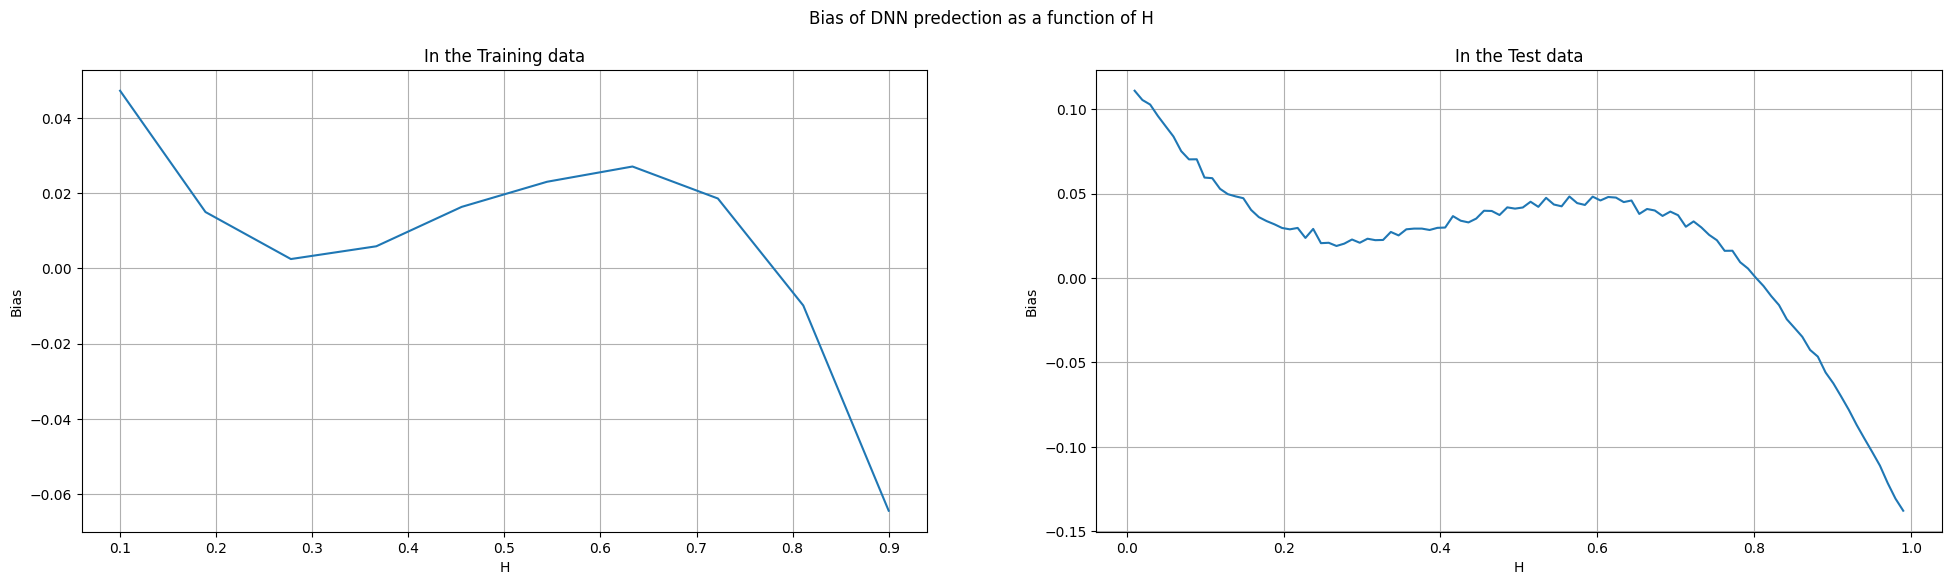

In [58]:
# Calculating bias

#In the training data prediction
Bias_train_data=[np.mean(H_predict_train[i*M_train:(i+1)*M_train])-H_train_range[i] for i in range(len(H_train_range))]
#in the test data predection 
Bias_test_data=[np.mean(H_predict_test[i*M_test:(i+1)*M_test])-H_test_range[i] for i in range(len(H_test_range))]

#Plotting the bias as a function of H
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Bias of DNN predection as a function of H')

axs[0].set_title(r'In the Training data')
axs[1].set_title(r'In the Test data')

axs[0].plot(H_train_range,Bias_train_data)
axs[1].plot(H_test_range,Bias_test_data)

for i in [0,1]:
    axs[i].set_xlabel(r'H')
    axs[i].set_ylabel(r'Bias')
    axs[i].grid()

plt.show()

We can make the following remarks:
- The order of magnitude of the bias is greater in the Test data which is to be expected.
- The bias is greater around extreme values especially in the test data and outside of the learning range of the Hurst parameter, this is to be expected as the NN has not been trained around such values.
- the increasing tendency of the bias (in absolute value) around extreme values suggests that it will continue to increase the more we get closer to 0 and 1.

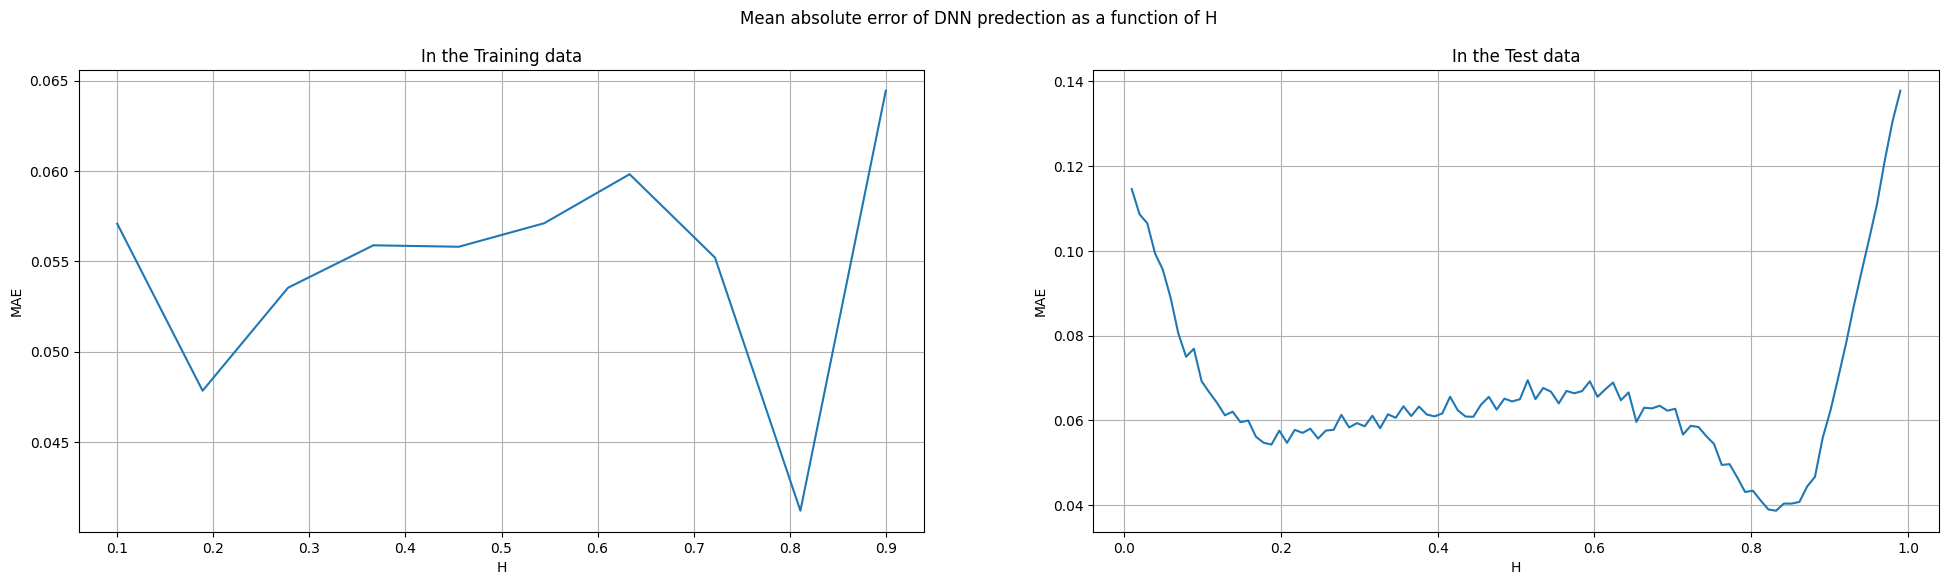

In [59]:
# Calculating mean absolute error

#In the training data prediction
MAE_train_data=[np.mean(np.abs(H_predict_train[i*M_train:(i+1)*M_train]-H_train_range[i])) for i in range(len(H_train_range))]
#in the test data predection 
MAE_test_data=[np.mean(np.abs(H_predict_test[i*M_test:(i+1)*M_test]-H_test_range[i])) for i in range(len(H_test_range))]

#Plotting the bias as a function of H
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Mean absolute error of DNN predection as a function of H')

axs[0].set_title(r'In the Training data')
axs[1].set_title(r'In the Test data')

axs[0].plot(H_train_range,MAE_train_data)
axs[1].plot(H_test_range,MAE_test_data)

for i in [0,1]:
    axs[i].set_xlabel(r'H')
    axs[i].set_ylabel(r'MAE')
    axs[i].grid()

plt.show()

Like the case of bias We can make the following remarks:
- The order of magnitude of the MAE is greater in the Test data which is to be expected.
- The MAE is greater around extreme values especially in the test data and outside of the learning range of the Hurst parameter, this is to be expected as the NN has not been trained around such values.

Errors of 10^(-1) order (around extreme values in the Test data) are not promising as Hurst coefficients are in the range [0,1].
Errors around H=0.5 can be more problematic as they can shift the behaviour of the time series from a positively correlated one to a negatively correlated one.

CNN

In [60]:
def CNN(N_input):
    
    model_CNN = keras.models.Sequential()
    act = tf.keras.layers.LeakyReLU(alpha=0.01)
    model_CNN.add(keras.layers.Conv1D(32, 20, activation=act, padding='same',input_shape=(N_input,1)))
    model_CNN.add(keras.layers.MaxPooling1D(pool_size=3, padding = 'same'))
    model_CNN.add(keras.layers.Dropout(0.25))
    model_CNN.add(keras.layers.Conv1D(64, 20, activation=act,padding='same'))
    model_CNN.add(keras.layers.MaxPooling1D(pool_size=3, padding = 'same'))
    model_CNN.add(keras.layers.Dropout(0.25))
    model_CNN.add(keras.layers.Conv1D(128, 20, activation=act, padding='same'))
    model_CNN.add(keras.layers.MaxPooling1D(pool_size=3, padding = 'same'))
    model_CNN.add(keras.layers.Dropout(0.4))
    model_CNN.add(keras.layers.Flatten())
    model_CNN.add(keras.layers.Dense(128, activation = act))
    model_CNN.add(keras.layers.Dropout(0.3))
    model_CNN.add(tf.keras.layers.Dense(1,  activation='linear'))

    model_CNN.compile(loss='mse', optimizer='adam')
    
    return model_CNN 

In [61]:
model_CNN = CNN(T)
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           672       
                                                                 
 max_pooling1d (MaxPooling1  (None, 34, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 34, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 34, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 64)           

In [ ]:
#Preparing data in accepted format
X_train_scaled_expanded = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled_expanded  = np.expand_dims(X_test_scaled, axis=2)

In [62]:
if Trained_CNN==False:
    model_CNN.fit(X_train_scaled_expanded, Y_train, batch_size=32, epochs=30)
    save_model(model_CNN, 'model_CNN.h5')
else :
    model_CNN=load_model('model_CNN.h5')

Epoch 1/30
3125/3125 [==============================] - 126s 38ms/step - loss: 0.0050
Epoch 2/30
3125/3125 [==============================] - 113s 36ms/step - loss: 0.0017
Epoch 3/30
3125/3125 [==============================] - 113s 36ms/step - loss: 0.0014
Epoch 4/30
3125/3125 [==============================] - 119s 38ms/step - loss: 0.0013
Epoch 5/30
3125/3125 [==============================] - 113s 36ms/step - loss: 0.0021
Epoch 6/30
3125/3125 [==============================] - 119s 38ms/step - loss: 0.0029
Epoch 7/30
3125/3125 [==============================] - 111s 36ms/step - loss: 0.0013
Epoch 8/30
3125/3125 [==============================] - 112s 36ms/step - loss: 0.0035
Epoch 9/30
3125/3125 [==============================] - 113s 36ms/step - loss: 0.0021
Epoch 10/30
3125/3125 [==============================] - 111s 35ms/step - loss: 0.0029
Epoch 11/30
3125/3125 [==============================] - 112s 36ms/step - loss: 0.0016
Epoch 12/30
3125/3125 [=============================

In [ ]:
#predicting Hurst coefficient
H_predict_train_CNN = model_CNN.predict(X_train_scaled_expanded)
H_predict_test_CNN  = model_CNN.predict(X_test_scaled_expanded)

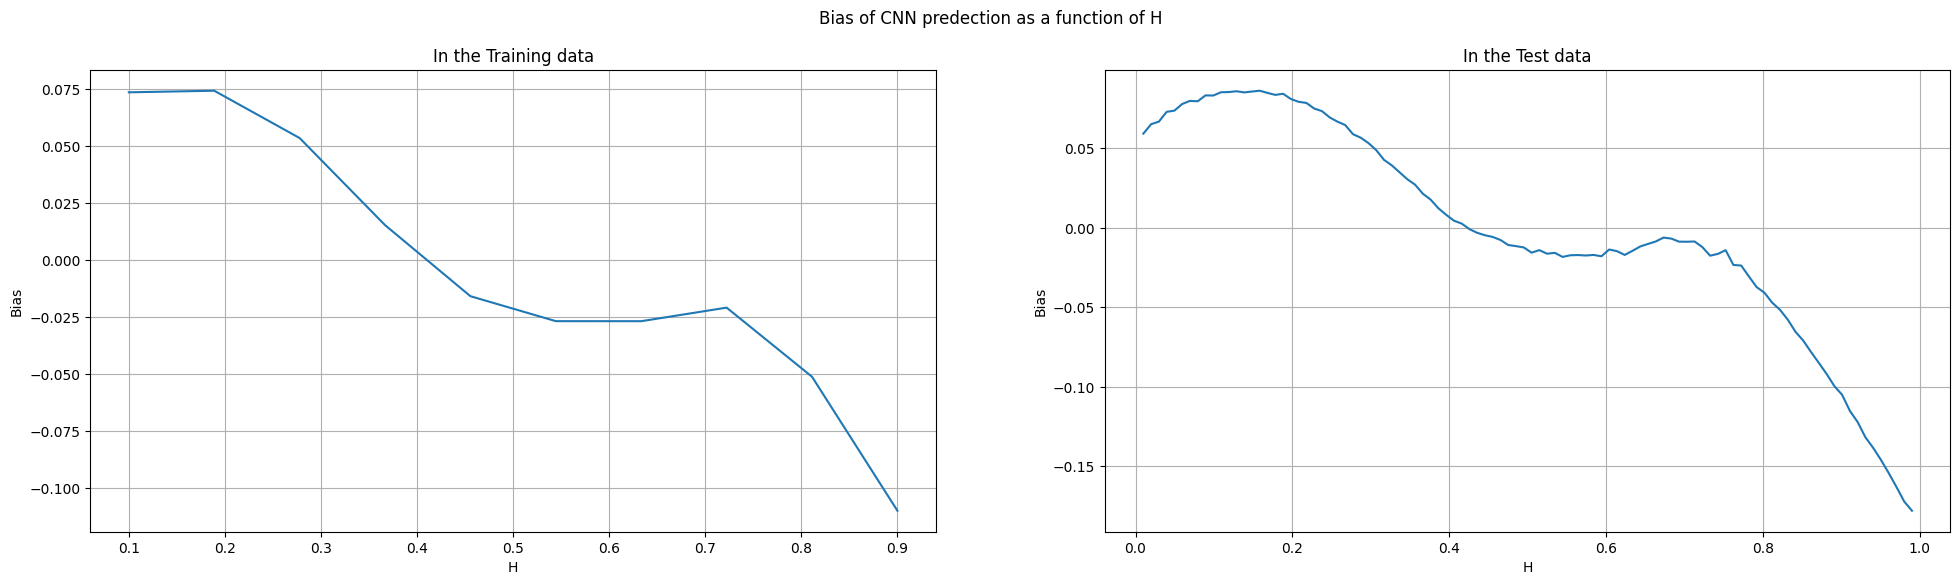

In [63]:
# Calculating bias

#In the training data prediction
Bias_train_data_CNN=[np.mean(H_predict_train_CNN[i*M_train:(i+1)*M_train])-H_train_range[i] for i in range(len(H_train_range))]
#in the test data predection 
Bias_test_data_CNN=[np.mean(H_predict_test_CNN[i*M_test:(i+1)*M_test])-H_test_range[i] for i in range(len(H_test_range))]

#Plotting the bias as a function of H
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Bias of CNN predection as a function of H')

axs[0].set_title(r'In the Training data')
axs[1].set_title(r'In the Test data')

axs[0].plot(H_train_range,Bias_train_data_CNN)
axs[1].plot(H_test_range,Bias_test_data_CNN)

for i in [0,1]:
    axs[i].set_xlabel(r'H')
    axs[i].set_ylabel(r'Bias')
    axs[i].grid()

plt.show()

We can make the same remarks around bias as for the DNN case however here we have:

- The order of magnitude of the bias in the data is better than in the DNN case around 0 (with bias here of 0.05 around 0 while it was 0.12 around zero in the DNN case ), However this compensated by worse results around 1.
- Strangely we notice that there is an asymetry in the learning of the Hurst coefficient, around very small values the bias has decreased however around great values (close to one), the bias persists to be high.

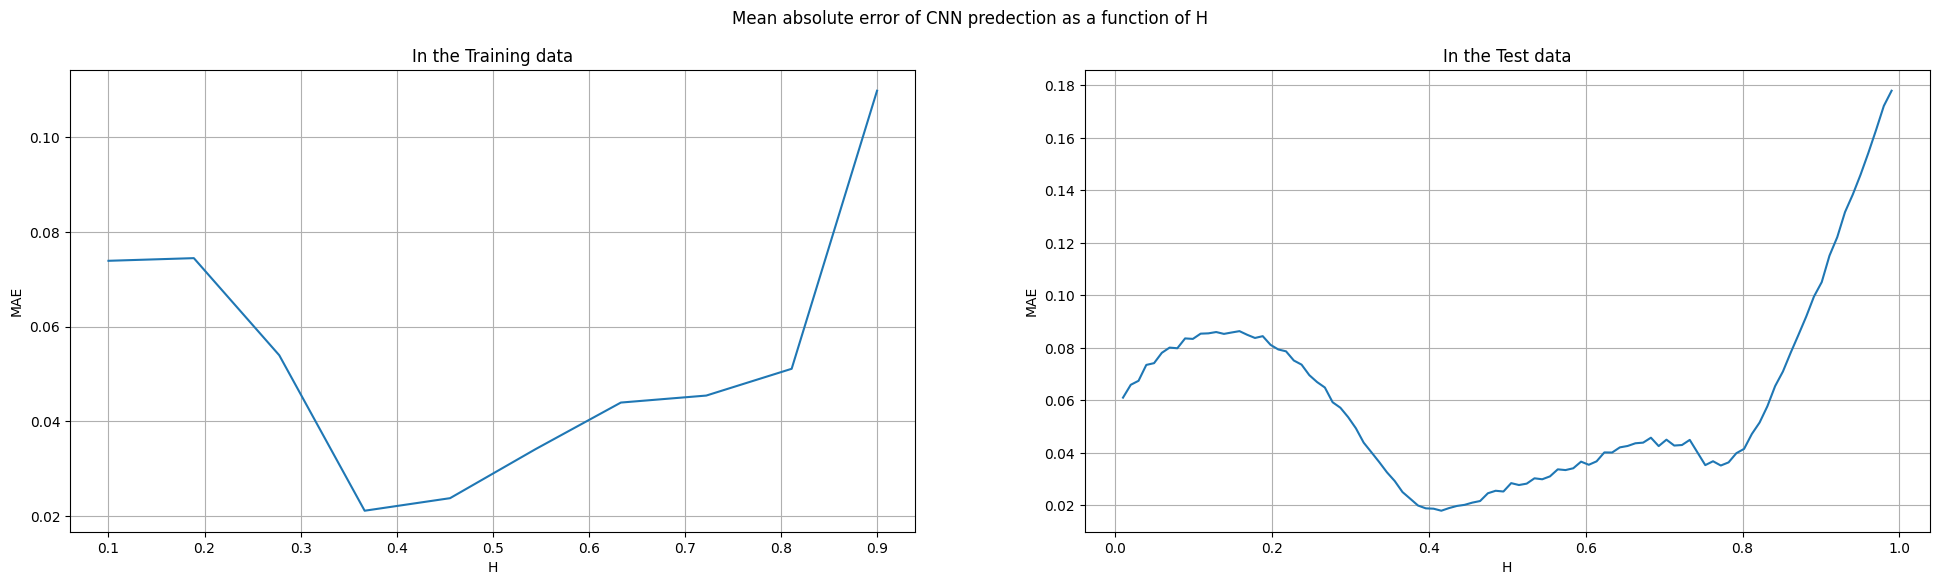

In [64]:
# Calculating mean absolute error

#In the training data prediction
MAE_train_data_CNN=[np.mean(np.abs(H_predict_train_CNN[i*M_train:(i+1)*M_train]-H_train_range[i])) for i in range(len(H_train_range))]
#in the test data predection 
MAE_test_data_CNN=[np.mean(np.abs(H_predict_test_CNN[i*M_test:(i+1)*M_test]-H_test_range[i])) for i in range(len(H_test_range))]

#Plotting the bias as a function of H
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Mean absolute error of CNN predection as a function of H')

axs[0].set_title(r'In the Training data')
axs[1].set_title(r'In the Test data')

axs[0].plot(H_train_range,MAE_train_data_CNN)
axs[1].plot(H_test_range,MAE_test_data_CNN)

for i in [0,1]:
    axs[i].set_xlabel(r'H')
    axs[i].set_ylabel(r'MAE')
    axs[i].grid()
    
plt.show()

The error has a behavious similair to the bias, and like in the case of bias we notice an improvement from the DNN case closer to zero.

Q5) How to improve the results of the estimator around extreme values ?
- We can add other features that depend on the Hurst coefficient; for example VAR[X_(t+y)-X_(t)]=y^(2*H), this property can be used to improve the estimation. Practicaly speaking we can add the empirical variance of the above mentioned property as a feature for each generated time series
- We can also use the self affinity property in the same manner

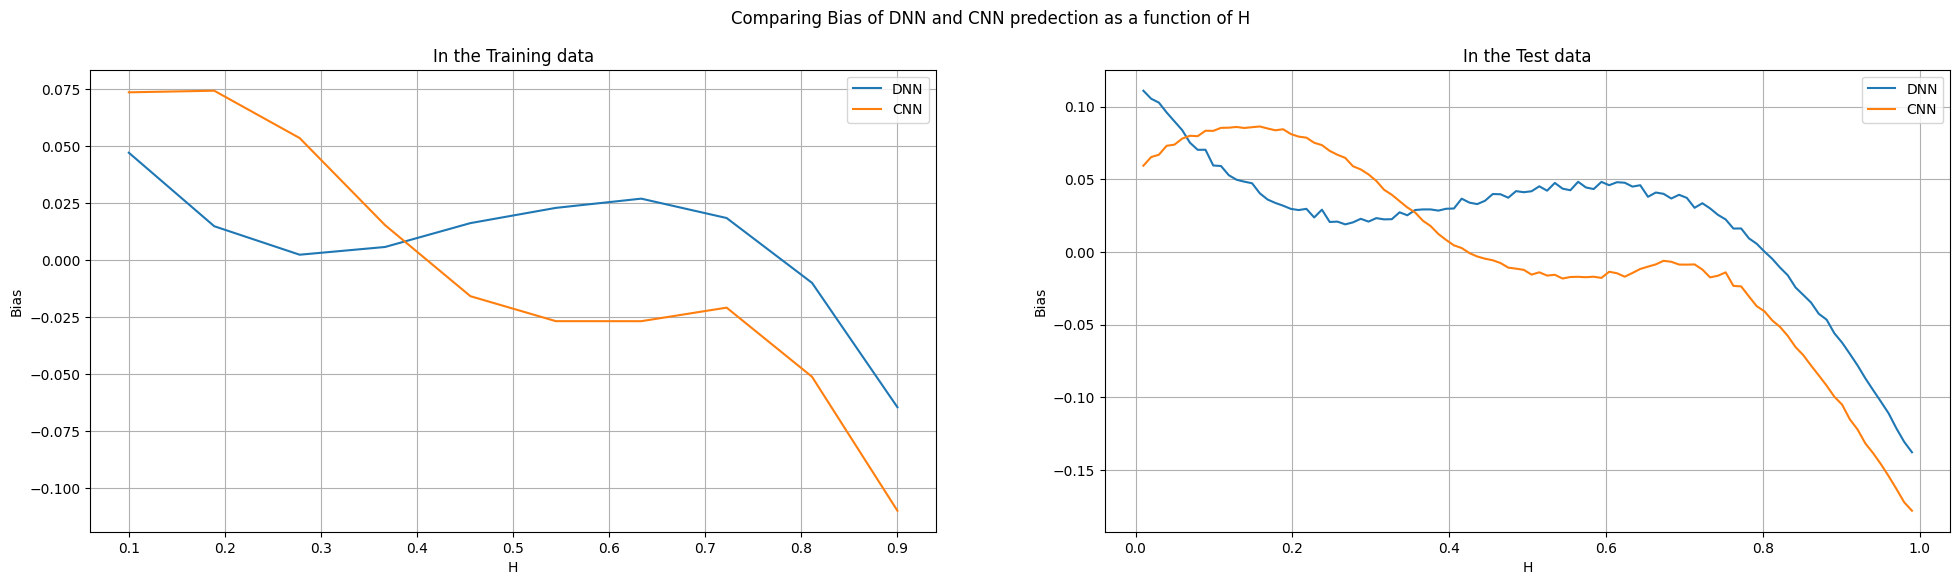

In [68]:
# Comparing Bias of DNN and CNN

#Plotting the bias as a function of H
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Comparing Bias of DNN and CNN predection as a function of H')

axs[0].set_title(r'In the Training data')
axs[1].set_title(r'In the Test data')

axs[0].plot(H_train_range,Bias_train_data,label='DNN')
axs[0].plot(H_train_range,Bias_train_data_CNN,label='CNN')

axs[1].plot(H_test_range,Bias_test_data,label='DNN')
axs[1].plot(H_test_range,Bias_test_data_CNN,label='CNN')

for i in [0,1]:
    axs[i].set_xlabel(r'H')
    axs[i].set_ylabel(r'Bias')
    axs[i].grid()
    axs[i].legend()


plt.show()

It is hard to confrim which prediction is bette as CNN to have better results for the range [0.4,0.7] of Hurst coefficient and close to zero but seems to underperform DNN outside of these ranges.

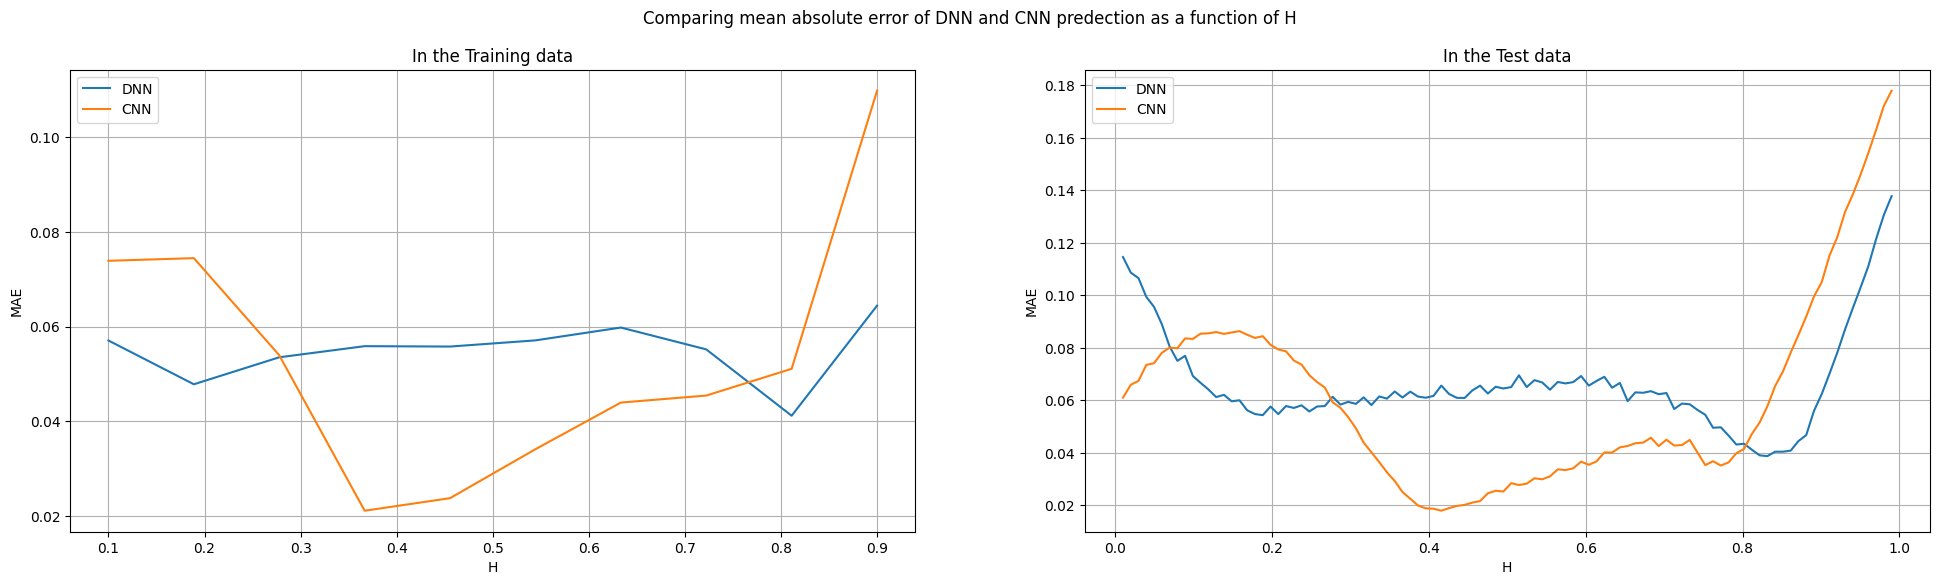

In [70]:
# Comparing Bias of DNN and CNN

#Plotting the bias as a function of H
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Comparing mean absolute error of DNN and CNN predection as a function of H')

axs[0].set_title(r'In the Training data')
axs[1].set_title(r'In the Test data')

axs[0].plot(H_train_range,MAE_train_data,label='DNN')
axs[0].plot(H_train_range,MAE_train_data_CNN,label='CNN')

axs[1].plot(H_test_range,MAE_test_data,label='DNN')
axs[1].plot(H_test_range,MAE_test_data_CNN,label='CNN')

for i in [0,1]:
    axs[i].set_xlabel(r'H')
    axs[i].set_ylabel(r'MAE')
    axs[i].grid()
    axs[i].legend()

plt.legend()
plt.show()

We can make similar remarks regarding the MAE as for the Bias 

Q7) How can we combine the predictions of both NN ? 
- Visually :  if we can see that the time series is positvely correlated this means that H>1/2 and DNN might provide better results especially in the range [0.8], otherwise if it is negativelly correlated H<1/2 CNN might be a better choice
- We can also average the estimations of both estimators, trying to capture the best behaviour possible (decreasing the bias than using the one with least favorable bias)